# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

**Подключаем библиотеки:**

- **pandas** - для работы с таблицами
- **numpy** - для получения последовательностей дробных чисел 
- **sklearn** - инструменты машинного обучения (модели классификации, метрики для исследования качества моделей, разделение данных на тренировочные, валидационные, тестовые выборки)

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

Загрузим каждый регион в отдельный датафрейм. Краткое описание мтодом **info()**.

In [70]:
geodata_0 = pd.read_csv('/datasets/geo_data_0.csv')
geodata_1 = pd.read_csv('/datasets/geo_data_1.csv')
geodata_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [71]:
def print_info(df):
    display(df.info())
    display(df.describe())
    print('Количество дубликатов:', df.duplicated().sum())
    print()
    print('Количество пропусков:')
    display(df.isna().sum())
    display(df.corr())
    pd.plotting.scatter_matrix(df, figsize=(12, 12));
    pass

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Количество дубликатов: 0

Количество пропусков:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


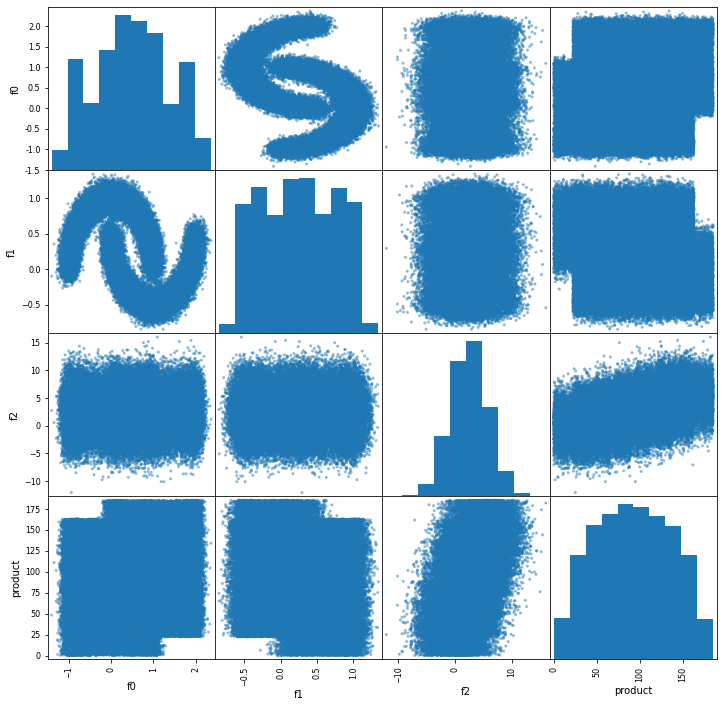

In [72]:
print_info(geodata_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Количество дубликатов: 0

Количество пропусков:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


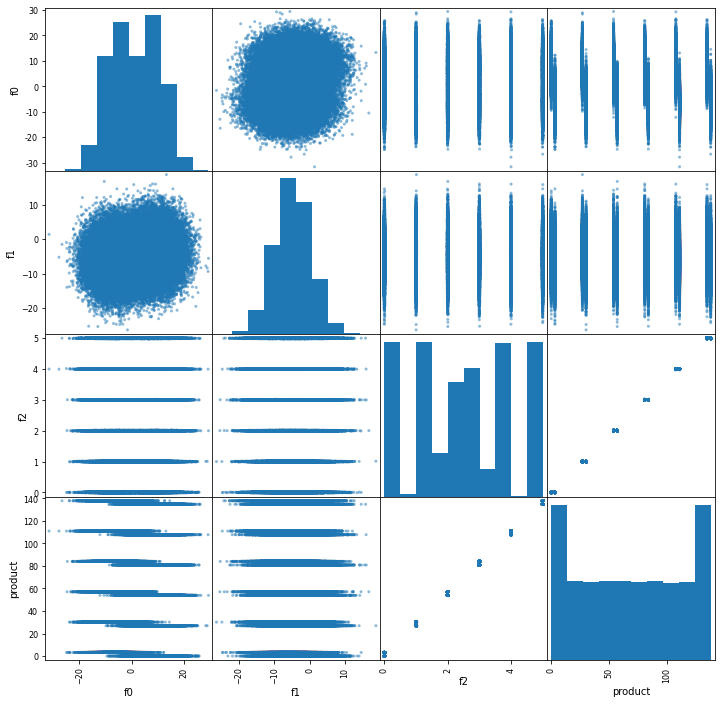

In [73]:
print_info(geodata_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Количество дубликатов: 0

Количество пропусков:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


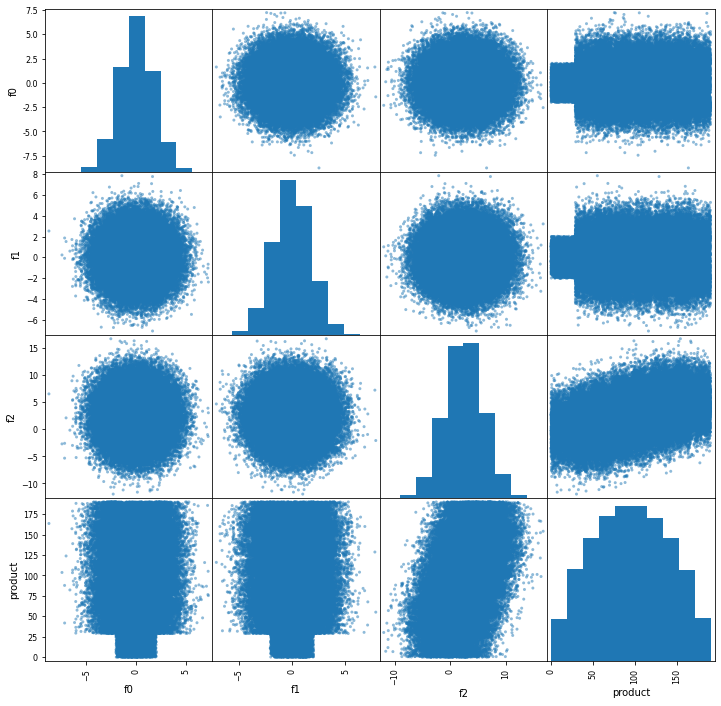

In [74]:
print_info(geodata_2)

- открыты и описаны данные из трёх датасетов по геологоразведке в регионах 0, 1, 2. Признаки f2 и 'product' в датасете geodata_1 распределены ненормально, сильно коррелируют между собой и практически не связаны с признаками f0, f1
- в данных не обнаружено пропусков и явных дубликатов

Для дальнейшего анализа удалим столбец id и подсчитаем количество нулевых значений целевого признака в датасетах.

In [75]:
geodata_0 = geodata_0.drop('id', axis=1)
geodata_1 = geodata_1.drop('id', axis=1)
geodata_2 = geodata_2.drop('id', axis=1)

def check_zeros(df, target):
    zeros = df[df[target] == 0][target].count()
    percent = zeros / df.shape[0]
    print('Количество нулевых значений -', zeros)
    print('Процент нулевых значений -', percent)

check_zeros(geodata_0, 'product')
check_zeros(geodata_1, 'product')
check_zeros(geodata_2, 'product')

Количество нулевых значений - 1
Процент нулевых значений - 1e-05
Количество нулевых значений - 8235
Процент нулевых значений - 0.08235
Количество нулевых значений - 1
Процент нулевых значений - 1e-05


**Данные готовы к обучению**.
- Данные успешно загружены, кратко описаны и проверены на наличие явных дубликатов и пропусков. 
- Признаки id удален, так как целевой признак от id никак не зависит.
- Во втором месторождении около 8,2% месторождений не имеет значения в столбце product. Количество нулевых значений в первом и третьем регионе равно одному, следовательно можно предположить, что в датасете по региону '1' в 8200 точках не было исследовано количество барелей нефти.
- По гистограммам распределения параметров, можно заметить, что у 0 и 2го региона распределение признаков скважин близкое к нормальному. В регионе 1 данные по f2 и 'product' имеют странное распределение и сильнейшую линейную зависимость между собой. Приэтом f2 и 'product' совсем не зависят от признаков f0 и f1.

## Обучение и проверка модели

### Выполняем разбивку неподготовленного датафрейма.

In [76]:
RANDOM_STATE = 12345
numeric = ['f0', 'f1', 'f2']

Напишем функцию разбиения на обучающую и валидационную выборку с масштабированием даннных и стратификацией по отсутствующим значениям. 

In [77]:
def test_split_scaled(df, target):
    zeros = df[df[target] == 0][target].count()
    features = df.drop(target , axis=1)
    targets = df[target]
    
    if zeros <= 1:
        features_train, features_valid, target_train, target_valid = train_test_split(
            features, targets, test_size=0.25, random_state=RANDOM_STATE)
    else:
        features_train, features_valid, target_train, target_valid = train_test_split(
            features, targets, test_size=0.25, random_state=RANDOM_STATE, stratify=targets)

    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])

    return features_train, features_valid, target_train, target_valid

Напишем функцию отбражения метрик для регрессий, применённых к датасетам.

In [78]:
def print_metrics(valid, predict):
    print('MAE:', round(mean_absolute_error(valid, predict), 0))
    print('RMSE:', round(((mean_squared_error(valid, predict))**0.5), 2))
    print('R2:',  round(r2_score(valid, predict), 2))
    print('Средний предсказанный запас сырья:', round(predict.mean(), 0))
    pass

Применим функцию разбиения к датасетам и проведём проверку разбиения.  

In [79]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = test_split_scaled(geodata_0, 'product')
features_train_1, features_valid_1, target_train_1, target_valid_1 = test_split_scaled(geodata_1, 'product')
features_train_2, features_valid_2, target_train_2, target_valid_2 = test_split_scaled(geodata_2, 'product')
#Проверка разделения
data_list = [features_train_0, target_train_0, features_valid_0, target_valid_0,
             features_train_1, target_train_1, features_valid_1, target_valid_1,
             features_train_2, target_train_2, features_valid_2, target_valid_2]
for i in data_list:
    print('Количество строк и столбцов:', i.shape)

Количество строк и столбцов: (75000, 3)
Количество строк и столбцов: (75000,)
Количество строк и столбцов: (25000, 3)
Количество строк и столбцов: (25000,)
Количество строк и столбцов: (75000, 3)
Количество строк и столбцов: (75000,)
Количество строк и столбцов: (25000, 3)
Количество строк и столбцов: (25000,)
Количество строк и столбцов: (75000, 3)
Количество строк и столбцов: (75000,)
Количество строк и столбцов: (25000, 3)
Количество строк и столбцов: (25000,)


### Проверим показатели на маштабированных данных LinearRegression с автоматическими значениями гиперпараметров.

Уточним все возможные параметры **LinearRegression**.

In [80]:
model_lr = LinearRegression()
display(model_lr.get_params().keys())

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

Линейная регрессия без оптимизации. Все предсказанные значения сохраним в переменной с префиксом lr_.

In [83]:
def lr_func(df, target, model):
    features_train, features_valid, target_train, target_valid = test_split_scaled(df, target)
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    print('Показатели региона:')
    print_metrics(target_valid, predicted_target)
    return predicted_target

In [85]:
print('Регион 0')
lr_predicted_target_0 = lr_func(geodata_0, 'product', model_lr)

Регион 0
Показатели региона:
MAE: 31.0
RMSE: 37.58
R2: 0.28
Средний предсказанный запас сырья: 93.0


In [86]:
print('Регион 1')
lr_predicted_target_1 = lr_func(geodata_1, 'product', model_lr)

Регион 1
Показатели региона:
MAE: 1.0
RMSE: 0.89
R2: 1.0
Средний предсказанный запас сырья: 69.0


In [87]:
print('Регион 2')
lr_predicted_target_2 = lr_func(geodata_2, 'product', model_lr)

Регион 2
Показатели региона:
MAE: 33.0
RMSE: 40.03
R2: 0.21
Средний предсказанный запас сырья: 95.0


### Проверим показатели на маштабированных данных LinearRegression с подбором гиперпараметров и кросс-валидацией.

Линейная регрессия c оптимизацией гиперпараметров и кросс-валидацией **GridSearchCV**. Все предсказанные значения сохраним в переменной с префиксом lrgs_.

In [56]:
#выберем наиболее значимые гиперпараметры и запишем их в словарь lr_parameters
lr_parameters = { 
                  'copy_X': [True, False],
                  'fit_intercept': [True, False],
                  'n_jobs':[-1, 0, 1],
                  'positive': [True, False],
                  'normalize': [True, False]
                    }
model_lr = LinearRegression()
#оптимизация LR по rmse = 'neg_root_mean_squared_error'
lr_gscv = GridSearchCV(model_lr, lr_parameters, cv=5, scoring='neg_root_mean_squared_error')

In [88]:
print('Регион 0')
lrgs_predicted_target_0 = lr_func(geodata_0, 'product', lr_gscv)
print('Гиперпараметры линейной регрессии с наилучшим rmse:') 
print(lr_gscv.best_params_)

Регион 0
Показатели региона:
MAE: 31.0
RMSE: 37.58
R2: 0.28
Средний предсказанный запас сырья: 93.0
Гиперпараметры линейной регрессии с наилучшим rmse:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'normalize': True, 'positive': False}


In [89]:
print('Регион 1')
lrgs_predicted_target_1 = lr_func(geodata_1, 'product', lr_gscv)
print('Гиперпараметры линейной регрессии с наилучшим rmse:') 
print(lr_gscv.best_params_)

Регион 1
Показатели региона:
MAE: 1.0
RMSE: 0.89
R2: 1.0
Средний предсказанный запас сырья: 69.0
Гиперпараметры линейной регрессии с наилучшим rmse:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'normalize': True, 'positive': False}


In [90]:
print('Регион 2')
lrgs_predicted_target_2 = lr_func(geodata_2, 'product', lr_gscv)
print('Гиперпараметры линейной регрессии с наилучшим rmse:') 
print(lr_gscv.best_params_)

Регион 2
Показатели региона:
MAE: 33.0
RMSE: 40.03
R2: 0.21
Средний предсказанный запас сырья: 95.0
Гиперпараметры линейной регрессии с наилучшим rmse:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'normalize': True, 'positive': True}


### Проверим показатели на маштабированных данных с помощью линейной регрессии с кросс-валидацией (метод LassoCV с cv=5).

Линейная регрессия без оптимизациии гиперпараметров, но с кросс-валидацией **LassoCV**. Все предсказанные значения сохраним в переменной с префиксом lasso_.

In [60]:
lasso_cv = LassoCV(random_state=RANDOM_STATE)
display(lasso_cv.get_params().keys())

dict_keys(['alphas', 'copy_X', 'cv', 'eps', 'fit_intercept', 'max_iter', 'n_alphas', 'n_jobs', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'verbose'])

In [91]:
print('Регион 0')
lasso_predicted_target_0 = lr_func(geodata_0, 'product', lasso_cv)

Регион 0
Показатели региона:
MAE: 31.0
RMSE: 37.58
R2: 0.28
Средний предсказанный запас сырья: 93.0


In [92]:
print('Регион 1')
lasso_predicted_target_1 = lr_func(geodata_1, 'product', lasso_cv)

Регион 1
Показатели региона:
MAE: 1.0
RMSE: 0.89
R2: 1.0
Средний предсказанный запас сырья: 69.0


In [93]:
print('Регион 2')
lasso_predicted_target_2 = lr_func(geodata_2, 'product', lasso_cv)

Регион 2
Показатели региона:
MAE: 33.0
RMSE: 40.03
R2: 0.21
Средний предсказанный запас сырья: 95.0


- Изменение стандартных значений гиперпараметров **LinearRegression** не улучшило модель . 
- Использование **LassoCV** также не улучшило показатели линейной регрессии, но использовать его удобнее

**Оценим общий запас по регионам**.

In [94]:
predict_0 = [lr_predicted_target_0, lrgs_predicted_target_0, lasso_predicted_target_0]
print('Суммарный предсказанный запас в регионе 0:')
for x in predict_0:
    print(round(lr_predicted_target_0.sum()))
print('Суммарный реальный запас в регионе 0 -', round(target_valid_0.sum()))
print()
predict_1 = [lr_predicted_target_1, lrgs_predicted_target_1, lasso_predicted_target_1]
print('Суммарный предсказанный запас в регионе 1:')
for x in predict_1:
    print(round(x.sum()))
print('Суммарный реальный запас в регионе 1 -', round(target_valid_1.sum()))
print()
predict_2 = [lr_predicted_target_2, lrgs_predicted_target_2, lasso_predicted_target_2]
print('Суммарный предсказанный запас в регионе 2:')
for x in predict_2:
    print(round(x.sum()))
print('Суммарный реальный запас в регионе 2 -', round(target_valid_2.sum()))

Суммарный предсказанный запас в регионе 0:
2314814
2314814
2314814
Суммарный реальный запас в регионе 0 - 2301965

Суммарный предсказанный запас в регионе 1:
1720756
1720756
1720755
Суммарный реальный запас в регионе 1 - 1720625

Суммарный предсказанный запас в регионе 2:
2374126
2374139
2374157
Суммарный реальный запас в регионе 2 - 2372106


**Вывод по пункту 2**
- Данные предсказаний о количестве нефти примерно совпадают с реальными значениями, но больше их. 
- Лучше всего модель предсказала запасы во втором регионе (RMSE - 0.89), далее в первом и третьем соотвественно.
- Возможно все модели переобучилась.

## Подготовка к расчёту прибыли

- Создадим переменные об экономической информации.
- Расчитаем безубыточную разработку сырья на 200 месторождениях. 
- Найдем среднее количество продукта в месторождениях необходимое для этого.

In [96]:
#Прибыль - в тысячах рублей за тысячу барелей, поэтому исходные параметры сохранены без трёх нулей
BUDGET = 1e+07 
CHOSEN_POINTS = 500
BEST_POINTS = 200
PRICE_PER_BARREL = 450

average_profit_per_point = round(BUDGET/BEST_POINTS)
print('Средняя прибыль на лучшую точку -', average_profit_per_point, 'тыс.руб.')
average_barrels_per_point = round(average_profit_per_point/PRICE_PER_BARREL)
print('Средний объем нефти на точку для окупаемости -', average_barrels_per_point, 'тыс. барелей')
average_barrels = round(BUDGET/PRICE_PER_BARREL)
print('Средний объем нефти на регион -', average_barrels, 'тыс. барелей')

Средняя прибыль на лучшую точку - 50000 тыс.руб.
Средний объем нефти на точку для окупаемости - 111 тыс. барелей
Средний объем нефти на регион - 22222 тыс. барелей


In [119]:
def deposit_hist(product, bins, xlim_max, ylim_max):
    plt.figure(figsize=[10, 6])
    plt.hist(product, bins=bins)
    
    plt.xlim([0, xlim_max])
    plt.ylim([0, ylim_max])
    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")
    plt.title("Гистограмма распределения по объему скважин")
    plt.show()
    pass

Средний запас фактичекой нефти на скважину в регионе 0: 93 тыс. барелей. Отклонение: 44 тыс. барелей.


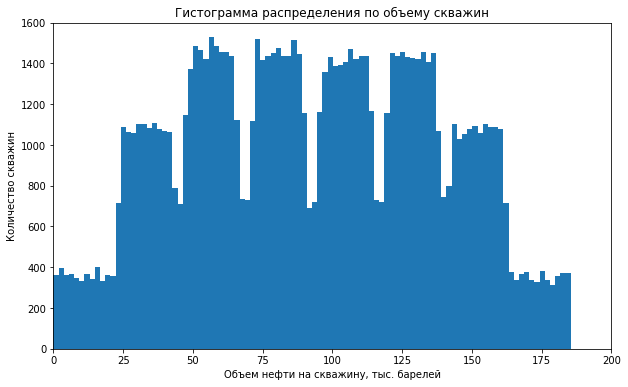

In [124]:
print('Средний запас фактичекой нефти на скважину в регионе 0:',
      round(geodata_0['product'].mean()), 'тыс. барелей. Отклонение:', round(geodata_0['product'].std()), 'тыс. барелей.')
deposit_hist(geodata_0['product'], 100, 200, 1600)

Средний запас фактичекой нефти на скважину в регионе 1: 69 тыс. барелей. Отклонение: 46 тыс. барелей.


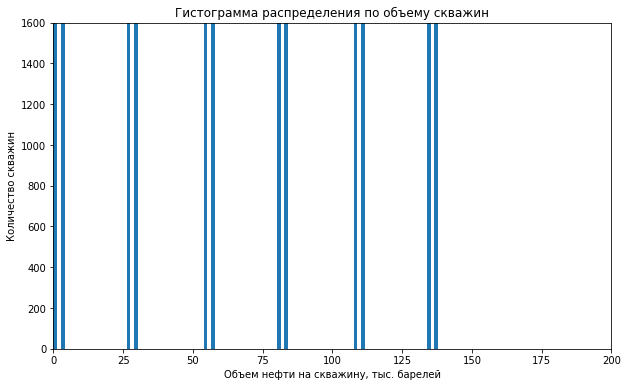

In [125]:
print('Средний запас фактичекой нефти на скважину в регионе 1:',
      round(geodata_1['product'].mean()), 'тыс. барелей. Отклонение:', round(geodata_1['product'].std()), 'тыс. барелей.')
deposit_hist(geodata_1['product'], 100, 200, 1600)

Средний запас фактичекой нефти на скважину в регионе 2: 95 тыс. барелей. Отклонение: 45 тыс. барелей.


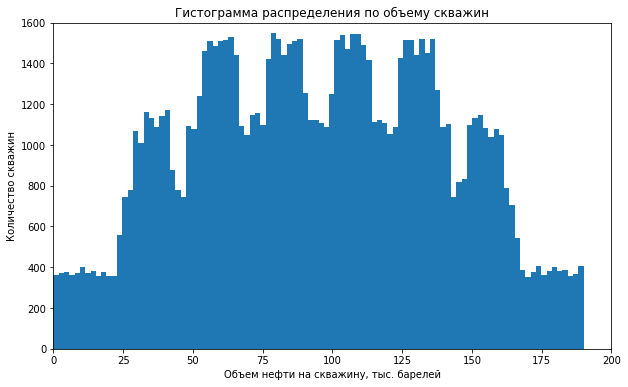

In [127]:
print('Средний запас фактичекой нефти на скважину в регионе 2:',
      round(geodata_2['product'].mean()), 'тыс. барелей. Отклонение:', round(geodata_2['product'].std()), 'тыс. барелей.')
deposit_hist(geodata_2['product'], 100, 200, 1600)

Минимального объём окупаемости - 111 тыс. руб. лежит не сильно правее среднего значения, поэтому можно подобрать самые прибыльные.


Создадим функции для расчета приыбыли на 500 разведанных точек

In [128]:
def revenue(target, predict):
    predict_sorted = predict.sort_values(ascending=False)
    selected = target[predict_sorted.index][:BEST_POINTS]
    revenue = selected.sum()*PRICE_PER_BARREL - BUDGET
    return revenue

**Вывод по шагу 3:**
- Была подготовлена средняя оценка прибыли за скважину и средний объем на скважину. 
- Изучены средние фактические запасы. Для первого и третьего - есть вероятность окупить затраты. 
- Написана функцию расчета прибыли 200 наиболее прибыльных скважин

## Расчёт прибыли и рисков 

Напишем функцию bootstrap c iter=1000.

In [135]:
def bootstrap(target, predict):
    state = np.random.RandomState(RANDOM_STATE)
    values = []
    count = 0 
    
    target = target.reset_index(drop=True)
    predictions = pd.Series(predict)
 
    for i in range(1000):
        target_subsample = target.sample(n=CHOSEN_POINTS, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        value = revenue(target_subsample, predictions_subsample)/1000
        values.append(value)
        
        if value < 0:
            count += 1 
        
    risk = count / 1000
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975) 
    
    print('Средняя прибыль по региону составляет:', round(values.mean(), 2), 'тыс. руб с риском в',
          round(risk * 100, 2), '%')
    print('Доверительный интервал прибыли в регионе составляет от', round(lower, 2),'до', round(upper, 2), 'тыс. руб')
    pass

Для каждого из региона методом **bootstrap** посчитаем среднюю прибыль, риски и доверительный интервал тремя типами линейных регрессий

In [136]:
print('Регион 0:')
for pred in predict_0:
    bootstrap(target_valid_0, pred)

Регион 0:
Средняя прибыль по региону составляет: 425.94 тыс. руб с риском в 6.0 %
Доверительный интервал прибыли в регионе составляет от -102.09 до 947.98 тыс. руб
Средняя прибыль по региону составляет: 425.94 тыс. руб с риском в 6.0 %
Доверительный интервал прибыли в регионе составляет от -102.09 до 947.98 тыс. руб
Средняя прибыль по региону составляет: 426.28 тыс. руб с риском в 6.1 %
Доверительный интервал прибыли в регионе составляет от -104.47 до 947.86 тыс. руб


In [137]:
print('Регион 1:')
for pred in predict_1:
    bootstrap(target_valid_1, pred)

Регион 1:
Средняя прибыль по региону составляет: 500.15 тыс. руб с риском в 0.7 %
Доверительный интервал прибыли в регионе составляет от 80.2 до 942.19 тыс. руб
Средняя прибыль по региону составляет: 500.15 тыс. руб с риском в 0.7 %
Доверительный интервал прибыли в регионе составляет от 80.2 до 942.19 тыс. руб
Средняя прибыль по региону составляет: 500.13 тыс. руб с риском в 0.7 %
Доверительный интервал прибыли в регионе составляет от 80.2 до 942.19 тыс. руб


In [138]:
print('Регион 2:')
for pred in predict_2:
    bootstrap(target_valid_2, pred)

Регион 2:
Средняя прибыль по региону составляет: 435.01 тыс. руб с риском в 6.4 %
Доверительный интервал прибыли в регионе составляет от -128.88 до 969.71 тыс. руб
Средняя прибыль по региону составляет: 435.44 тыс. руб с риском в 6.4 %
Доверительный интервал прибыли в регионе составляет от -128.88 до 966.79 тыс. руб
Средняя прибыль по региону составляет: 435.84 тыс. руб с риском в 6.7 %
Доверительный интервал прибыли в регионе составляет от -132.05 до 966.79 тыс. руб


**Вывод по шагу 4**
- Данные были обработаны и рассчитаны прибыль, интервал и риски.
- После расчёта рисков и выручки 0 и 2 регион можно исключить из-за высоких рисков. Самая высокая средняя выручка, а так же самые минимальные риски у региона-1, но к данным из этого региона есть большие вопросы. 
- Доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин в регионе 1 окупится.
- Если исключить регион 1 из-за подозрительных данных, то можно остановить выбор на регионе 0, с меньшим риском. 

**Итоговый вывод**

- Изучены данные. Проведена подготовка данных к моделированию.
- Обучены три типа линейных регрессий (LinearRegression, LinearRegression+GridSearchCV, LassoCV) для трёх регионов.
- Составлена функция расчета прибыли в регионе.
- Посчитана прибыль и риски в каждом регионе.
- Регион 1 лидирует по показателям, хотя в данных подозрительная распределённость признаков f2, 'product' и сильная линейная корреляция между ними, и полное отсутствие зависимости от признаков f0 и f1. Учитывая это, можно рассмотреть и регион 0.